## Light Curve drawing 
##### Procedures
1. Setting up a orbit
2. Consitute the binary system
3. Drawing the light curve
##### Parameters
1. stellar masses
2. orbital period
3. orbital eccentricity 
4. orbital inclination

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mp 
import math
from numba import jit, int32, float64, njit, prange
from astropy import constants as const
from astropy import units


In [79]:
# Some constants (SI unit)
G           = const.G
AU          = const.au
sigma       = const.sigma_sb
mass_sun    = const.M_sun
pi          = np.pi
sin         = np.sin
cos         = np.cos
asin        = np.arcsin
acos        = np.arccos


In the binary system, stars orbit along an elliptical path, surrounding their COM, which sits the focus for both ellipses. Thus, it's better choose the COM as the origin of the coordinate.

In [80]:
def star_coor(m1,m2,r,theta,inc):
    '''
    Assumption: 
    1. the shape of stars is spherical 
    2. the stars have circular orbits with synchronous rotation
    ##################################################################
    input:
    m1      : the mass of star1
    m2      : the mass of star2
    r       : the distance between stars 
    theta   : the pahse angle
    inc     : orbital inclination 
    ##################################################################
    output:
    q       : the mass ratio of binary system
    X       : the projection of the relative position of the binary on the x axis 
    Y       : the projection of the relative position of the binary on the y axis 
    Z       : the projection of the relative position of the binary on the z axis 
    x1      : the projection of position of star1 on x axis
    y1      : the projection of position of star1 on y axis
    z1      : the projection of position of star1 on z axis
    x2      : the projection of position of star1 on x axis
    y2      : the projection of position of star1 on y axis
    z2      : the projection of position of star1 on z axis

    '''
    q = m1/m1 
    X = r*sin(theta)
    Y = r*cos(theta)*cos(inc)
    Z = r*cos(theta)*sin(inc)
    x1 = -X/(1+1/q)
    y1 = -Y/(1+1/q)
    z1 = -Z/(1+1/q)
    x2 = X/(1/q)
    y2 = Y/(1/q)
    z2 = Z/(1/q)

Consider the limb-darkening effect and assume the emergent intensity is I0, which emitted from stellar dick center as the blackbody radiation that is descibed by using Stefan-Boltzmann law

In [81]:
# def flux_per_stellar_element(sigma,T,x,gamma):
#     '''
#     The intensity described by the Stefan-Boltzmann law is 
#     I = sigma x T^4 x (1+x+xcos(gamma))
#     x is the limb-darkening coef.
#     gamma is an angle betweenthe radius vector and the line-of-sight vector
#     '''
#     sigma = const.sigma_sb


For the detached binary system, choose XY cet as the target.

In [82]:
# Needed parameters of XY cet
totalphase  = 2
smapling    = 2
inc         = 87.6
Temp_h      = 7970.0 # temperature of the hotter star
# Th
Temp_c      = 7620.0 # temperature of the colder star
# Tc
Mass_h      = 1.773  # mass of the hotter star (solar unit)
# Mh
Mass_c      = 1.615  # mass of the colder star (solar unit)
# Mc
Radius_h    = 1.873  # the radius of the hotter star (solar unit)
# Rh
Radius_c    = 1.773  # the radius of the colder star (solar unit)
# Rc
semia       = 12.493/Radius_h # the semimajor axis (solar unit)
# sma
period      = 2.78071392 # the period of the elicpsing (per day)
Flux_h      = sigma*(Temp_h*units.K)**4 # the flux of the hotter star
# fluxh
Flux_c      = sigma*(Temp_c*units.K)**4 # the flux of the colder star
# fluxc
x_h         = 0 # the limb-darkening coef.
# xh
x_c         = 0 # the limb-darkening coef.
# xc

In our simulation, the primary star is always the hotter star; wile the secondary star is always the colder star

In [83]:
if (Radius_h > Radius_c): 
    '''
    p: primary star
    s: secnodary star
    '''
    mass_p      = Mass_h/Mass_h
    mass_s      = Mass_c/Mass_h
    radius_p    = Radius_h/Radius_h
    radius_s    = Radius_c/Radius_h
    flux_p      = Flux_h/Flux_h
    flux_s      = Flux_c/Flux_h
    phi         = 0
    # the starting angle for the orbit: 
    # secondary star is in front of the primary star 
else:
    mass_p      = Mass_c/Mass_c
    mass_s      = Mass_h/Mass_c
    radius_p    = Radius_c/Radius_c
    radius_s    = Radius_h/Radius_c
    flux_p      = Flux_c/Flux_c
    flux_s      = Flux_h/Flux_c
    phi         = pi
    # the starting angle for the orbit: 
    # secondary star is behind of the primary star 

Let's calculate the intensity of the binary system without eclipse

In [84]:
# In the codition without eclipse
drp1 = np.linspace(0, radius_p, 151)
drs1 = np.linspace(0, radius_s, 151)
# limb-darkening
ldangle_p       = asin((drp1-(drp1[1]-drp1[0])/2)/radius_p)
ldangle_s       = asin((drs1-(drs1[1]-drs1[0])/2)/radius_s)
ldangle_p[0]    = 0.0
ldangle_s[0]    = 0.0
# flux
ldflux_p = flux_p*(1-x_h*(1-cos(ldangle_p)))
ldflux_s = flux_s*(1-x_c*(1-cos(ldangle_s)))
# intenisty
ldintensity_p = ldflux_p*(drp1-(drp1[1]-drp1[0])/2)*(drp1[1]-drp1[0])*2*pi
ldintensity_s = ldflux_s*(drs1-(drs1[1]-drs1[0])/2)*(drs1[1]-drs1[0])*2*pi
ttintensity_p = np.sum(ldintensity_p)
ttintensity_s = np.sum(ldintensity_s)
print('total intensity of primary star =', ttintensity_p)
print('total intensity of secondary star =', ttintensity_s)

total intensity of primary star = 3.141453027249633
total intensity of secondary star = 2.352117897488358


In [85]:
# The inclination angle change with radian
inc_change      = np.deg2rad(inc) # deg to rad
q               = mass_s/mass_p   # mass ratio
ldintensity     = np.array([], dtype=float) 
luminosity      = np.array([], dtype=float) # y axis is the luminosity
phaseset        = np.array([], dtype=float) # x axis is the phase of the binary system
phaserange      = np.linspace(0,360,int(totalphase*smapling*360+1))
print(len(phaserange))

1441


In [86]:
# Compute the light curve
drp = radius_p/150.0
drs = radius_s/150.0
for t in phaserange:
    phase = t/360
    phaseangle = phi + 2*pi*phase
    # the projection of the relative position of binary system on the x-y plane
    X = semia*sin(phaseangle)
    Y = semia*cos(phaseangle)*cos(inc_change)
    Z = semia*cos(phaseangle)*sin(inc_change)
    # the coordinate of stars
    xp = -X/(1+(1/q))
    yp = -Y/(1+(1/q))
    zp = -Z/(1+(1/q))
    xs = X/(1/q)
    ys = Y/(1/q)
    zs = Z/(1/q)
    # the distance between stars on x-y plane
    disance = np.hypot(xp-xs,yp-ys)
    # initialize 
    ldintensity     = 0.0
    ttintensity     = 0.0
    angle_start     = 0.0
    # check if there is eclipsing or not
    if (disance > (radius_p+radius_s)): 
        # no eclipse
        ttintensity = ttintensity_p+ttintensity_s
    elif (disance < (radius_p-radius_s)) and (zp > zs): 
        # full eclipse and primary star is in front of secondary star
        ttintensity = ttintensity_p
    ##########################################################################################
    # sedondary star is in front of the primary star with the eclipse
    if (zs > zp) and (disance < (radius_p+radius_s)):
        r_upper = radius_p
        r_limit = 0.0
        while ((r_upper - drp/2)>=r_limit):
            if (r_upper > abs(radius_s-disance)):
                theta_p = acos((r_upper**2 - radius_s**2 + disance**2)/(2*disance*r_upper))
                # cosine rule
            else: # theta_p = 0 or pi
                if ((disance-radius_s) > 0):
                    theta_p = 0.0
                else: 
                    theta_p = pi
            ldangle  = asin((r_upper-drp/2)/radius_p)
            # the radius of limb-darkering is the middle of drp
            ldeffect = flux_p*(1-x_h*(1-cos(ldangle)))
            ldplus   = 0.0
            if (theta_p < pi):
                dangle  = theta_p-angle_start
                ldplus  = ldeffect*drp*r_upper*dangle
            intensity   = ldeffect*(r_upper-drp/2)*drp*2*theta_p + ldplus
            ldintensity = np.append(ldintensity,intensity)
            angle_start = theta_p
            r_upper     -= drp
            # until r_upper < r_limit, stop the loop
        ecilpse     = np.sum(ldintensity)
        ttintensity = ttintensity_p + ttintensity_s - ecilpse
    ##########################################################################################
    # primary star is in front of the secondary star with the eclipse
    if (zs < zp) and ((radius_p-radius_s) < disance < (radius_p+radius_s)):
        r_upper = radius_s
        r_limit = 0.0
        while ((r_upper - drs/2)>=r_limit):
            if (r_upper > abs(radius_p-disance)):
                theta_p = acos((r_upper**2 - radius_p**2 + disance**2)/(2*disance*r_upper))
                # cosine rule
            else: # theta_p = 0 or pi
                if ((disance-radius_p) > 0):
                    theta_p = 0.0
                else: 
                    theta_p = pi
            ldangle  = asin((r_upper-drs/2)/radius_s)
            # the radius of limb-darkering is the middle of drp
            ldeffect = flux_s*(1-x_c*(1-cos(ldangle)))
            ldplus   = 0.0
            if (theta_p < pi):
                dangle  = theta_p-angle_start
                ldplus  = ldeffect*drp*r_upper*dangle
            intensity   = ldeffect*(r_upper-drs/2)*drs*2*theta_p + ldplus
            ldintensity = np.append(ldintensity,intensity)
            angle_start = theta_p
            r_upper     -= drs
            # until r_upper < r_limit, stop the loop
        ecilpse     = np.sum(ldintensity)
        ttintensity = ttintensity_p + ttintensity_s - ecilpse
    luminosity = np.append(luminosity,ttintensity)
    phaseset   = np.append(phaseset,phase)

print(len(luminosity))
print(len(phaseset))


1441
1441


Check the flux

In [87]:
flux_max   = np.max(luminosity)
flux_ratio = luminosity/flux_max
flux_ratio = np.append(flux_ratio,flux_ratio)
phaseset   = np.append(phaseset,phaseset-1)
index      = np.argsort(phaseset)
print(len(phaseset))
print(len(flux_ratio))
phaseset   = phaseset[index]
flux_ratio = flux_ratio[index]


2882
2882


Plotting the light curve

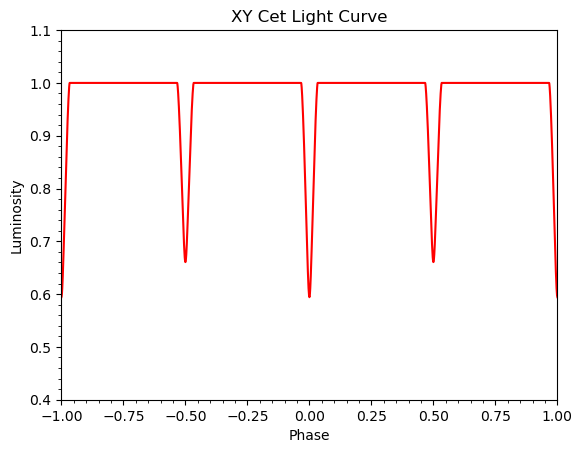

In [88]:
plt.figure()
plt.ylim(0.4,1.1)
plt.xlim(-1,1)
plt.plot(phaseset,flux_ratio,'r-',label='synthesis')
plt.title('XY Cet Light Curve')
plt.ylabel('Luminosity')
plt.xlabel('Phase')
plt.minorticks_on()